## Reading and analysis of NorESM CAM diagnostics files

This notebook provides an interface to read, structure and analyse CAM diagnostics files (see e.g. [here](https://github.com/jgliss/my_notebooks/blob/master/data/from_ada/table_GLBL_ANN_obs.asc) in order to highlight performance of the model runs with respect to each other, relative to observation data (NEED LINK FOR OBS DATA).

MAYBE SOME MORE TEXT HERE IN GENERAL WHAT THIS ALL IS ABOUT

In [1]:
%matplotlib inline
import pandas as pd
from glob import glob
import os
import helper_funcs as helpers
import ipywidgets as ipw

### 1. Paths and global settings (GLOB)  

Please change accordingly if you execute this notebook on your local machine.

#### 1.1. Paths (PATHS)

Here you can specify your paths.

In [2]:
#folder with ascii files
data_dir = "./data/michael_ascii_read/"
file_type = "webarchive"

# file containing additional information about variables (long names, can be interactively updated below)
varinfo_csv = "./data/var_info.csv"

# Config file for different groups
vargroups_cfg = "./data/varconfig.ini"

#directy to store results
output_dir = "./output/"

#### 1.2 Global settings (SETUP)

In the following cells you can specify global default settings.

##### 1.2.1 Define group of variables that you are interested in

Default group of variables. Variable groups can be defined in [varconfig.ini](https://github.com/jgliss/my_notebooks/blob/master/data/varconfig.ini). Use ``[group_name]`` to define a new group and add below all variables that should belong to the group in the desired display order (should be self-explanatory when looking at the file, I hope).

In [3]:
var_group = "fluxes" #group_name (AS STRING, e.g. "test") from varconfig.ini (use None, if you want to use all)

##### 1.2.2 Add data columns to index

Use the following list to specify table columns that should be added to the multiindex (Ada, here is where you can add "Obs").

In [4]:
add_to_index = [] #NEEDS TO BE A LIST, EVEN FOR ONLY ONE ITEM

##### 1.2.3 Define which parts of index should be unstacked

The following list can be used to specify how the final lists are displayed. The items in the list need to be names of sub-indices in the the Multiindex of the originally loaded file (i.e. "Run", "Years", "Variable", "Description") or data columns that were added to index (previous option). 

All values specified here will be unstacked, i.e. put from the original row into a column index representation (makes table view wider).

In [5]:
unstack_indices = ["Run", "Years"]

##### 1.2.4 Define index levels used for computing statistics (i.e. RMSE relative error)

Specify list of index level names of the original index that are used to compute the mean RMSE (e.g. if you specify

    ["Run", "Years"]
    
than the average RMSE of all runs and years will be computed (for each variable individually).

In [6]:
rmse_stats = ["Run", "Years"]

### 2. Importing and editing supplementary information

Let's begin with reading additional variable information from the file ``varinfo_csv``. Note that this is not strictly required but helps us below to display the results in a more intuitive manner, when analysing the data.

Note that the following method makes sure the CSV file exists, i.e. if it has not been created before, the information is loaded from Michaels Excel table and then saved at ``varinfo_csv``.

In [7]:
var_info_dict = helpers.load_varinfo(varinfo_csv)

The following cell opens an interactive widget that can be used to edit the information available for each variable (stored in file ``varinfo_csv``, see previous cell).

In [8]:
from my_widgets import EditDictCSV

edit_config = EditDictCSV(varinfo_csv)
#show
edit_config()

Now update to the current selection (run everything below if you change the previous cell).

In [9]:
var_info_dict = edit_config.var_dict

### 3. Search and load ASCII files, either using .asc or .webarchive file type (GET_FILES)

The following cell finds all files in folder ``data_dir``.

In [10]:
files = sorted(glob(data_dir + "*.{}".format(file_type)))
for file in files:
    print(file)    

./data/michael_ascii_read/N1850C53CLM45L32_f09_tn11_191017 (yrs 71-100).webarchive
./data/michael_ascii_read/N1850_f09_tn14_230218 (yrs 1-20).webarchive
./data/michael_ascii_read/N1850_f19_tn14_r227_ctrl (yrs 185-215).webarchive
./data/michael_ascii_read/N1850_f19_tn14_r227_ctrl (yrs 310-340).webarchive
./data/michael_ascii_read/N1850_f19_tn14_r227_ctrl (yrs 80-110).webarchive
./data/michael_ascii_read/N1850_f19_tn14_r265_ctrl_20180411 (yrs 90-120).webarchive


##### 3.1 Shortcuts for Run IDs (optional may also be changed interactively below)

Define list of shortnames for model runs or define a prefix. If undefined (i.e. empty list and ``None``), the original names are used.

In [11]:
# either
run_ids = list("ABCD") #renames the first 4 runs
# or
run_id_prefix = None #"Run"


### 4. Importing multiple result files and concatenating them into one Dataframe (LOAD_FILES)

In the following, we load all files into one `Dataframe`. 

To do this, a custom method `read_and_merge_all` was defined in [helper_funcs.py](https://github.com/jgliss/my_py3_scripts/blob/master/notebooks/helper_funcs.py). The method basically loops over all files and calls the method ``read_file_custom``, which you can also find in [helper_funcs.py](https://github.com/jgliss/my_py3_scripts/blob/master/notebooks/helper_funcs.py). 

In [12]:
merged = helpers.read_and_merge_all(file_list=files, var_info_dict=var_info_dict, replace_runid_prefix=run_id_prefix)
merged

Flag  \
Run                               Years  Variable           Description                        
N1850C53CLM45L32_f09_tn11_191017  71-100 RESTOM             Top model net flux           1.0   
                                         RESSURF            SRF net flux                 1.0   
                                         RESTOA_CERES-EBAF  TOA  net flux                1.0   
                                         RESTOA_ERBE        TOA  net flux                1.0   
                                         SOLIN_CERES-EBAF   Insolation                   1.0   
                                         SOLIN_CERES        Insolation                   1.0   
                                         CLDTOT_ISCCP       Total cloud cover            1.0   
                                         CLDTOT_CLOUDSAT    Total cloud cover            1.0   
                                         FLDS_ISCCP         LW down SRF                  1.0   
                                         FLNS_ISCCP         LW net SRF                   1.0   
                                         FLUT_CERES-EBAF    LW up Top                    1.0   
                                         FLUT_CERES         LW up Top                    1.0   
                                         FLUT_ERBE          LW up Top                    1.0   
                                         FLUTC_CERES-EBAF   LW up Top Clearsky           1.0   
                                         FLUTC_CERES        LW up Top Clearsky           1.0   
                                         FLUTC_ERBE         LW up Top Clearsky           1.0   
                                         FLNT_CAM           LW net Top                   1.0   
                                         FSDS_ISCCP         SW down SRF                  1.0   
                                         FSNS_ISCCP         SW net SRF                   1.0   
                                         FSNS_LARYEA        SW net SRF                   1.0   
                                         FSNTOA_CERES-EBAF                               0.0   
                                         FSNTOA_CERES       SW net TOA                   1.0   
                                         FSNTOA_ERBE        SW net TOA                   1.0   
                                         FSNTOAC_CERES-EBAF                              0.0   
                                         FSNTOAC_CERES      SW net TOA clearsky          1.0   
                                         FSNTOAC_ERBE       SW net TOA clearsky          1.0   
                                         FSNT_CAM           SW net Top                   1.0   
                                         LHFLX_JRA25        Lat Heat Flux                1.0   
                                         LHFLX_ERA40        Lat Heat Flux                1.0   
                                         LHFLX_WHOI         Lat Heat Flux                1.0   
...                                                                                      ...   
N1850_f19_tn14_r265_ctrl_20180411 90-120 PRECT_GPCP         Precipitation                1.0   
                                         PREH2O_NVAP        Precipitable water           1.0   
                                         PREH2O_AIRS        Precipitable water           1.0   
                                         PREH2O_JRA25       Precipitable water           1.0   
                                         PREH2O_ERAI        Precipitable water           1.0   
                                         PREH2O_ERA40       Precipitable water           1.0   
                                         PSL_JRA25          SeaLev pressure              1.0   
                                         PSL_ERAI           SeaLev pressure              1.0   
                                         SHFLX_JRA25        Sens Heat Flux               1.0   
                                         SHFLX_NCEP     

### 5. Rearranging and restructuring of the imported data (REARRANGE)

#### 5.1 Computing RMSE relative error (GET_RMSE_REL)

In the following we extract the subset containing the *RSME* information of the flagged variables for all runs in order to compute the relative error for each run based on the average *RMSE* of all runs:

$$\frac{RMSE_{Run}\,-\,\overline{RMSE_{All\,Runs}}}{\overline{RMSE_{All\,Runs}}}$$


In [13]:
merged = helpers.calc_and_add_relerror(merged, colname="RMSE", unstack_indices=rmse_stats)
merged

Flag  \
Run                               Years  Variable           Description                        
N1850C53CLM45L32_f09_tn11_191017  71-100 RESTOM             Top model net flux           1.0   
                                         RESSURF            SRF net flux                 1.0   
                                         RESTOA_CERES-EBAF  TOA  net flux                1.0   
                                         RESTOA_ERBE        TOA  net flux                1.0   
                                         SOLIN_CERES-EBAF   Insolation                   1.0   
                                         SOLIN_CERES        Insolation                   1.0   
                                         CLDTOT_ISCCP       Total cloud cover            1.0   
                                         CLDTOT_CLOUDSAT    Total cloud cover            1.0   
                                         FLDS_ISCCP         LW down SRF                  1.0   
                                         FLNS_ISCCP         LW net SRF                   1.0   
                                         FLUT_CERES-EBAF    LW up Top                    1.0   
                                         FLUT_CERES         LW up Top                    1.0   
                                         FLUT_ERBE          LW up Top                    1.0   
                                         FLUTC_CERES-EBAF   LW up Top Clearsky           1.0   
                                         FLUTC_CERES        LW up Top Clearsky           1.0   
                                         FLUTC_ERBE         LW up Top Clearsky           1.0   
                                         FLNT_CAM           LW net Top                   1.0   
                                         FSDS_ISCCP         SW down SRF                  1.0   
                                         FSNS_ISCCP         SW net SRF                   1.0   
                                         FSNS_LARYEA        SW net SRF                   1.0   
                                         FSNTOA_CERES-EBAF                               0.0   
                                         FSNTOA_CERES       SW net TOA                   1.0   
                                         FSNTOA_ERBE        SW net TOA                   1.0   
                                         FSNTOAC_CERES-EBAF                              0.0   
                                         FSNTOAC_CERES      SW net TOA clearsky          1.0   
                                         FSNTOAC_ERBE       SW net TOA clearsky          1.0   
                                         FSNT_CAM           SW net Top                   1.0   
                                         LHFLX_JRA25        Lat Heat Flux                1.0   
                                         LHFLX_ERA40        Lat Heat Flux                1.0   
                                         LHFLX_WHOI         Lat Heat Flux                1.0   
...                                                                                      ...   
N1850_f19_tn14_r265_ctrl_20180411 90-120 PRECT_GPCP         Precipitation                1.0   
                                         PREH2O_NVAP        Precipitable water           1.0   
                                         PREH2O_AIRS        Precipitable water           1.0   
                                         PREH2O_JRA25       Precipitable water           1.0   
                                         PREH2O_ERAI        Precipitable water           1.0   
                                         PREH2O_ERA40       Precipitable water           1.0   
                                         PSL_JRA25          SeaLev pressure              1.0   
                                         PSL_ERAI           SeaLev pressure              1.0   
                                         SHFLX_JRA25        Sens Heat Flux               1.0   
                                         SHFLX_NCEP     

#### 5.2 Interactive manipulation of Dataframe (DF_EDIT)

The following table widget uses the loaded Dataframes and applies all settings that were defined above.  

**NOTE**: the following interactive widget is a ***BETA*** version, please let me know if something does not work. It should prepare the dataframe according to your specified options above so that you can run the whole notebook and get your output even if parts of the interactivity do not work yet or if you do not wish to use interactivity.

In [14]:
from my_widgets import TableEditor
EDITOR = TableEditor(df=merged, 
                     save_dir=output_dir, #defined above
                     preconfig_file=vargroups_cfg, #defined above
                     default_group=var_group, #defined above
                     new_run_names=run_ids, #defined above
                     add_to_index_vars=add_to_index, #defined above
                     unstack_indices=unstack_indices) #defined above
                   
EDITOR()

Now access the current selection and continue.

In [15]:
selection = EDITOR.df_edit
selection

Flag                              \
Run                                       A    B       C                  
Years                                71-100 1-20 185-215 310-340 80-110   
Variable          Description                                             
RESTOM            Top model net flux    1.0  1.0     1.0     1.0    1.0   
RESSURF           SRF net flux          1.0  1.0     1.0     1.0    1.0   
RESTOA_CERES-EBAF TOA  net flux         1.0  1.0     1.0     1.0    1.0   
RESTOA_ERBE       TOA  net flux         1.0  1.0     1.0     1.0    1.0   

                                             Model                         \
Run                                       D      A      B       C           
Years                                90-120 71-100   1-20 185-215 310-340   
Variable          Description                                               
RESTOM            Top model net flux    1.0 -0.489  0.987   0.468   0.327   
RESSURF           SRF net flux          1.0 -0.489  0.974   0.474   0.337   
RESTOA_CERES-EBAF TOA  net flux         1.0  1.529  3.075   2.553   2.412   
RESTOA_ERBE       TOA  net flux         1.0  1.529  3.075   2.553   2.412   

                                        ...       RMSE                        \
Run                                     ...          C                     D   
Years                                   ...    185-215 310-340 80-110 90-120   
Variable          Description           ...                                    
RESTOM            Top model net flux    ...        NaN     NaN    NaN    NaN   
RESSURF           SRF net flux          ...        NaN     NaN    NaN    NaN   
RESTOA_CERES-EBAF TOA  net flux         ...      9.011   8.937  8.872  9.827   
RESTOA_ERBE       TOA  net flux         ...      8.977   8.906  8.772  9.180   

                                      RMSE_ERR                                \
Run                                          A         B         C             
Years                                   71-100      1-20   185-215   310-340   
Variable          Description                                                  
RESTOM            Top model net flux       NaN       NaN       NaN       NaN   
RESSURF           SRF net flux             NaN       NaN       NaN       NaN   
RESTOA_CERES-EBAF TOA  net flux      -0.014764 -0.068695  0.004067 -0.004179   
RESTOA_ERBE       TOA  net flux       0.007827 -0.024228  0.006146 -0.001812   

                                                          
Run                                                    D  
Years                                   80-110    90-120  
Variable          Description                             
RESTOM            Top model net flux       NaN       NaN  
RESSURF           SRF net flux             NaN       NaN  
RESTOA_CERES-EBAF TOA  net flux      -0.011421  0.094991  
RESTOA_ERBE       TOA  net flux      -0.016831  0.028898  

[4 rows x 36 columns]

#### 5.3 Extracting the Bias of each model run relative to the observations (GET_BIAS)

Retrieving a table that illustrates the Bias of each run for each flagged variable is straight forward. We just extract the `Bias` column from our flagged frame:

In [16]:
bias = selection["Bias"]
bias

Run                                       A      B       C                 \
Years                                71-100   1-20 185-215 310-340 80-110   
Variable          Description                                               
RESTOM            Top model net flux -0.489  0.987   0.468   0.327  0.647   
RESSURF           SRF net flux       -0.489  0.974   0.474   0.337  0.643   
RESTOA_CERES-EBAF TOA  net flux       0.537  2.083   1.561   1.420  1.741   
RESTOA_ERBE       TOA  net flux       1.470  3.017   2.494   2.353  2.674   

Run                                       D  
Years                                90-120  
Variable          Description                
RESTOM            Top model net flux -0.075  
RESSURF           SRF net flux       -0.075  
RESTOA_CERES-EBAF TOA  net flux       1.021  
RESTOA_ERBE       TOA  net flux       1.954

#### 5.4 Extracting the RMSE error of each model run relative to the observations (GET_RMSE_ERR)

In section 5.1 we computed and added the relative RMSE error as a new column to the original table. These data can now be accessed as simply as the ``Bias`` table:

In [17]:
rmse_err_rel = selection["RMSE_ERR"]
rmse_err_rel

Run                                          A         B         C            \
Years                                   71-100      1-20   185-215   310-340   
Variable          Description                                                  
RESTOM            Top model net flux       NaN       NaN       NaN       NaN   
RESSURF           SRF net flux             NaN       NaN       NaN       NaN   
RESTOA_CERES-EBAF TOA  net flux      -0.014764 -0.068695  0.004067 -0.004179   
RESTOA_ERBE       TOA  net flux       0.007827 -0.024228  0.006146 -0.001812   

Run                                                    D  
Years                                   80-110    90-120  
Variable          Description                             
RESTOM            Top model net flux       NaN       NaN  
RESSURF           SRF net flux             NaN       NaN  
RESTOA_CERES-EBAF TOA  net flux      -0.011421  0.094991  
RESTOA_ERBE       TOA  net flux      -0.016831  0.028898

### 6. Conditional formatting of tables (Dataframes) (VISUALISE)

This section illustrates, how we can perform conditional formatting of the color tables. This can either be performed in the browser (rendering of HTML representation of Dataframe) or by plotting them as a heatmap using the [seaborn library](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

#### 6.1 HTML preview using pandas styling options (DISP_HTML_NOSAVE)

Use [pandas styling options](https://pandas.pydata.org/pandas-docs/stable/style.html) to render color formatted table preview. Gets us a nice preview, problem is, however, that it cannot be exported as png, pdf, etc. out of the box.

In the following, we use a custom display method `my_table_display` (that is defined in [helper_funcs.py](https://github.com/jgliss/my_py3_scripts/blob/master/notebooks/helper_funcs.py)) in order to perform colour formatting considering all rows and columns at the same time and furthermore, using a diverging colour map that is dynamically shifted such that value 0 corresponds to the colour white (method `shifted_color_map`) also if `-vmin != vmax` (like usually).

In [18]:
from helper_funcs import my_table_display
my_table_display(bias)

In [19]:
my_table_display(rmse_err_rel)

#### 6.2 Rendered preview using seaborn (DISP_AS_PLOT)

Render table preview in browser directly using [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html). Gets us a nice preview and the possibility to edit display and save figure as png, etc in a very flexible manner.

The following cell plots the Bias table as is. The subsequent 2 cells produce normalised heatmaps based on rowwise mean value or based on the values in a specified column.

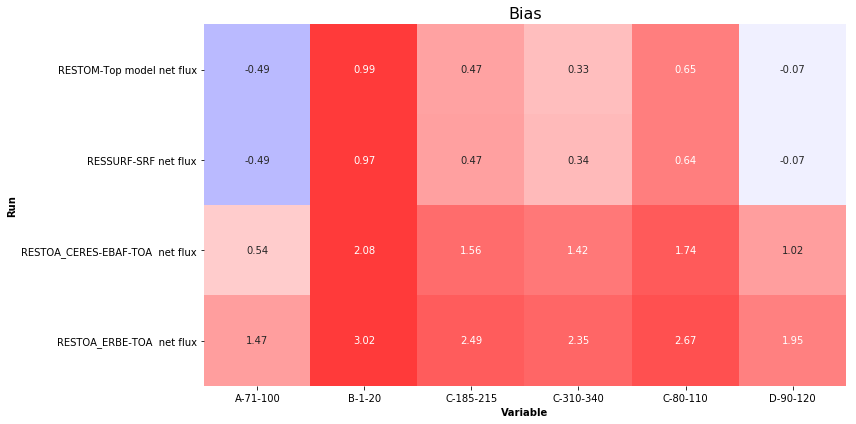

In [20]:
from helper_funcs import df_to_heatmap
ax = df_to_heatmap(bias, 
                   center=0, # table value that is mapped to the center of the colormap
                   color_rowwise=1, #apply color mapping rowwise
                   normalise_rows=0, # see next cell for an example
                   table_name="Bias",
                   figsize=(12,6))
ax.set_xlabel("Variable", weight="bold")
ax.set_ylabel("Run", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(output_dir, "bias_heatmap.png"))

Now the same but including a rowwise normalisation based on the mean bias in each row.

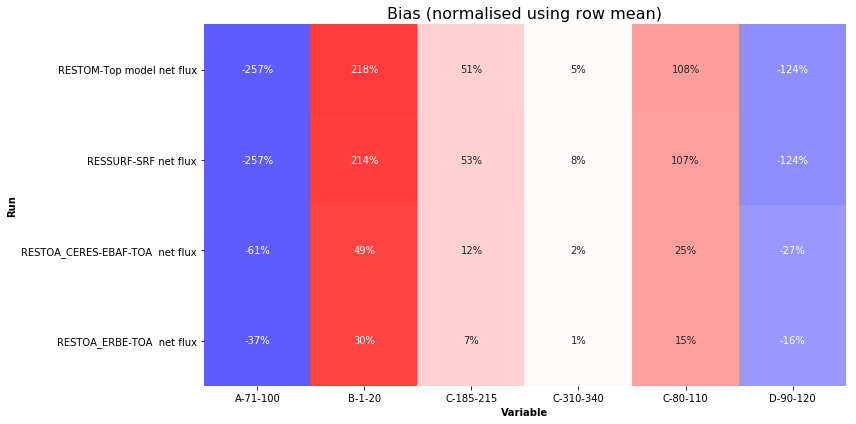

In [21]:
ax = df_to_heatmap(bias, 
                   center=0, # table value that is mapped to the center of the colormap
                   normalise_rows=1, # perform rowwise normalisation and plot percentage deviation from row mean
                   table_name="Bias",
                   figsize=(12,6))
ax.set_xlabel("Variable", weight="bold")
ax.set_ylabel("Run", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(output_dir, "bias_heatmap_deviation_rowmean.png"))

Now the same but including a rowwise normalisation based on the values in the 4th column.

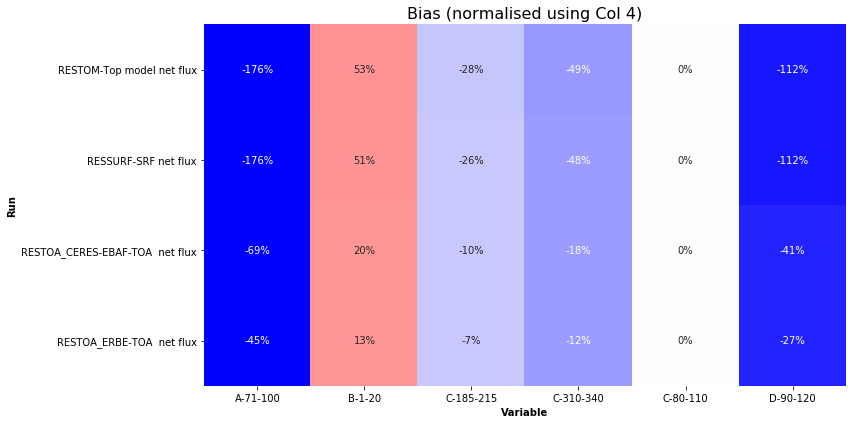

In [22]:
ax = df_to_heatmap(bias, 
                   center=0, # table value that is mapped to the center of the colormap
                   normalise_rows=1, # perform rowwise normalisation and plot percentage deviation from row mean
                   normalise_rows_col=4,
                   table_name="Bias",
                   figsize=(12,6))
ax.set_xlabel("Variable", weight="bold")
ax.set_ylabel("Run", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(output_dir, "bias_heatmap_deviation_rowmean.png"))

RMSE table

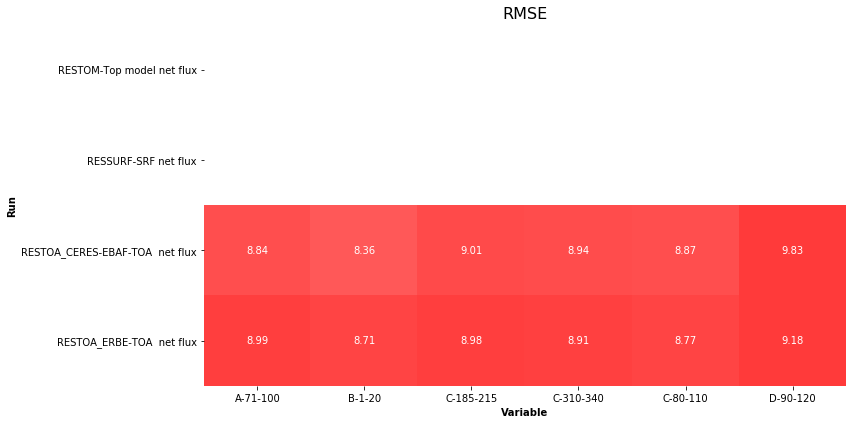

In [23]:
ax = df_to_heatmap(selection["RMSE"], 
                   table_name="RMSE",
                   figsize=(12,6))
ax.set_xlabel("Variable", weight="bold")
ax.set_ylabel("Run", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(output_dir, "rmse_heatmap.png"))

Now for the typical RMSE error

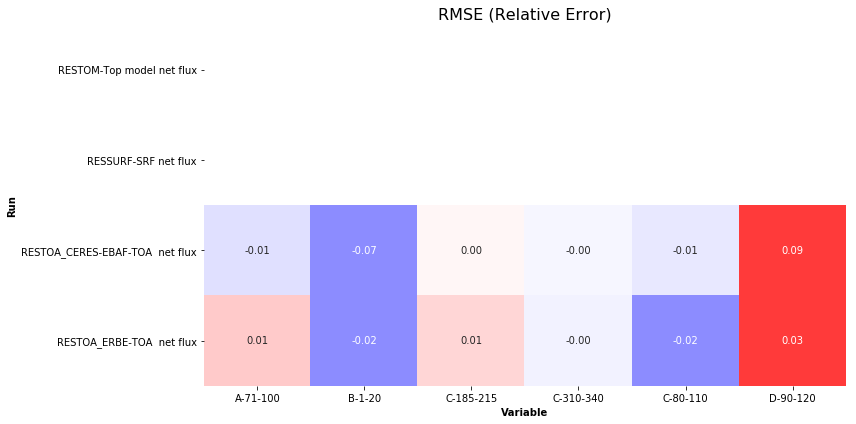

In [24]:
ax = df_to_heatmap(rmse_err_rel, 
                   table_name="RMSE (Relative Error)",
                   figsize=(12,6))
ax.set_xlabel("Variable", weight="bold")
ax.set_ylabel("Run", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(output_dir, "rmse_err_heatmap.png"))

### 7. Concatenate and save results (Bias and typical RMSE) as table (EXPORT)

In the following, the two result tables ``bias_table`` and ``typical_rmse`` are merged into one result table and then saved both as excel table and as csv file.

In [25]:
result = pd.concat([bias, rmse_err_rel],axis=1, keys=["Bias", "RMSE relative Error"])
result

Bias                                \
Run                                       A      B       C                  
Years                                71-100   1-20 185-215 310-340 80-110   
Variable          Description                                               
RESTOM            Top model net flux -0.489  0.987   0.468   0.327  0.647   
RESSURF           SRF net flux       -0.489  0.974   0.474   0.337  0.643   
RESTOA_CERES-EBAF TOA  net flux       0.537  2.083   1.561   1.420  1.741   
RESTOA_ERBE       TOA  net flux       1.470  3.017   2.494   2.353  2.674   

                                            RMSE relative Error            \
Run                                       D                   A         B   
Years                                90-120              71-100      1-20   
Variable          Description                                               
RESTOM            Top model net flux -0.075                 NaN       NaN   
RESSURF           SRF net flux       -0.075                 NaN       NaN   
RESTOA_CERES-EBAF TOA  net flux       1.021           -0.014764 -0.068695   
RESTOA_ERBE       TOA  net flux       1.954            0.007827 -0.024228   

                                                                              
Run                                          C                             D  
Years                                  185-215   310-340    80-110    90-120  
Variable          Description                                                 
RESTOM            Top model net flux       NaN       NaN       NaN       NaN  
RESSURF           SRF net flux             NaN       NaN       NaN       NaN  
RESTOA_CERES-EBAF TOA  net flux       0.004067 -0.004179 -0.011421  0.094991  
RESTOA_ERBE       TOA  net flux       0.006146 -0.001812 -0.016831  0.028898

Now save the table as excel file.

In [26]:
writer = pd.ExcelWriter('{}/result.xlsx'.format(output_dir))
result.to_excel(writer)
writer.save()
writer.close()